In [24]:
import pandas as pd

import numpy as np
import torch
from torch import nn, optim
from datasets import Dataset, load_dataset
from sentence_transformers import SentenceTransformer
from torch.utils.data import DataLoader
from torch.optim import AdamW
from tqdm import tqdm
import torch.nn.functional as F

from transformers import CLIPTextModel, CLIPTokenizer

In [2]:
import os
from dotenv import load_dotenv

os.chdir("/home/flexmatch_ftp/ftp/RAG-rec/config")
load_dotenv()

huggingface_Key = os.environ["huggingface_Key"]

In [3]:
from huggingface_hub import login

login(huggingface_Key)

In [4]:
all_data = pd.read_csv("/home/flexmatch_ftp/ftp/multimodal_categorizer/clip_fine_tuning/all_data.csv", index_col=0)

In [17]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 480595 entries, 0 to 480594
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   kor_original     480595 non-null  object
 1   translate        480595 non-null  object
 2   source_language  480595 non-null  object
 3   target_language  480595 non-null  object
dtypes: object(4)
memory usage: 18.3+ MB


In [6]:
TEACHER_MODEL_NAME = 'BAAI/bge-m3'
STUDENT_MODEL_NAME = 'openai/clip-vit-base-patch32'
BATCH_SIZE = 128
LR = 2e-5
NUM_EPOCHS = 3
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SAVE_PATH = "/home/flexmatch_ftp/ftp/multimodal_categorizer/clip_fine_tuning/clip_multilingual_student"

In [ ]:
class TranslationDataset(Dataset):
    def __init__(self, df):
        self.df = df.reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if isinstance(idx, (list, np.ndarray)):
            src_texts = self.df.loc[idx, "kor_original"].tolist()
            tgt_texts = self.df.loc[idx, "translate"].tolist()
            return {"src_text": src_texts, "tgt_text": tgt_texts}
        else:
            return {
                "src_text": self.df.loc[idx, "kor_original"],
                "tgt_text": self.df.loc[idx, "translate"]
            }


In [15]:
dataset = TranslationDataset(all_data)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [9]:
teacher_model = SentenceTransformer(TEACHER_MODEL_NAME, device=DEVICE)
teacher_model.eval()

SentenceTransformer(
  (0): Transformer({'max_seq_length': 8192, 'do_lower_case': False, 'architecture': 'XLMRobertaModel'})
  (1): Pooling({'word_embedding_dimension': 1024, 'pooling_mode_cls_token': True, 'pooling_mode_mean_tokens': False, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

In [10]:
student_tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
student_model = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32").to(DEVICE)
student_model.train()

CLIPTextModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e

In [ ]:
# optimizer = AdamW(student_model.parameters(), lr=LR)
# mse_loss = nn.MSELoss()

# for epoch in range(NUM_EPOCHS):
#     total_loss = 0
#     for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}"):
#         src_texts = batch["src_text"]
#         tgt_texts = batch["tgt_text"]

#         optimizer.zero_grad()

#         # teacher embedding 생성
#         with torch.no_grad():
#             teacher_src_emb = teacher_model.encode(
#                 src_texts,
#                 convert_to_tensor=True,
#                 device=DEVICE
#             )
#             teacher_tgt_emb = teacher_model.encode(
#                 src_texts,
#                 convert_to_tensor=True,
#                 device=DEVICE
#             )

#         # student embedding 생성
#         student_src_emb = student_model.encode(
#             src_texts,
#             convert_to_tensor = True,
#             device=DEVICE
#         )
#         student_tgt_emb = student_model.encode(
#             tgt_texts,
#             convert_to_tensor=True,
#             device=DEVICE
#         )

#         # mse loss 계산
#         loss_src = mse_loss(student_src_emb, teacher_src_emb)
#         loss_tgt = mse_loss(student_tgt_emb, teacher_tgt_emb)

#         # 역전파
#         loss.backward()
#         optimizer.step()
    
#     avg_loss = total_loss / len(dataloader)
#     print(f"Epoch {epoch+1} finished. Average Loss : {avg_loss:.4f}")


In [23]:
teacher_dim = teacher_model.get_sentence_embedding_dimension()  # teacher embedding 차원
student_dim = student_model.config.hidden_size                  # student hidden dim

projection = nn.Linear(student_dim, teacher_dim).to(DEVICE)

optimizer = AdamW(
    list(student_model.parameters()) + list(projection.parameters()), 
    lr=LR
)
mse_loss = nn.MSELoss()

for epoch in range(NUM_EPOCHS):
    total_loss = 0
    for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}"):
        src_texts = batch["src_text"]
        tgt_texts = batch["tgt_text"]

        optimizer.zero_grad()

        # --- Teacher embedding ---
        with torch.no_grad():
            teacher_src_emb = teacher_model.encode(src_texts, convert_to_tensor=True, device=DEVICE).detach().clone()
            teacher_tgt_emb = teacher_model.encode(tgt_texts, convert_to_tensor=True, device=DEVICE).detach().clone()

        # --- Student embedding ---
        # 1. 토크나이징
        src_inputs = student_tokenizer(src_texts, padding=True, truncation=True, return_tensors="pt").to(DEVICE)
        tgt_inputs = student_tokenizer(tgt_texts, padding=True, truncation=True, return_tensors="pt").to(DEVICE)

        # 2. 모델 통과
        student_src_out = student_model(**src_inputs)
        student_tgt_out = student_model(**tgt_inputs)

        # 3. mean pooling (sequence dim -> hidden dim)
        student_src_emb = student_src_out.last_hidden_state.mean(dim=1)
        student_tgt_emb = student_tgt_out.last_hidden_state.mean(dim=1)

        student_src_emb = projection(student_src_emb)
        student_tgt_emb = projection(student_tgt_emb)

        # --- loss 계산 ---
        loss_src = mse_loss(student_src_emb, teacher_src_emb)
        loss_tgt = mse_loss(student_tgt_emb, teacher_tgt_emb)
        loss = loss_src + loss_tgt

        # --- 역전파 & step ---
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1} finished. Average Loss : {avg_loss:.4f}")

student_model.save("/home/flexmatch_ftp/ftp/multimodal_categorizer/clip_fine_tuning")

Epoch 1: 100%|██████████| 3755/3755 [20:09<00:00,  3.10it/s]


Epoch 1 finished. Average Loss : 0.0022


Epoch 2: 100%|██████████| 3755/3755 [19:53<00:00,  3.15it/s]


Epoch 2 finished. Average Loss : 0.0010


Epoch 3: 100%|██████████| 3755/3755 [19:54<00:00,  3.14it/s]

Epoch 3 finished. Average Loss : 0.0008


In [45]:
# projection layer 저장
torch.save(projection.state_dict(), "/home/flexmatch_ftp/ftp/multimodal_categorizer/clip_fine_tuning/projection.pt")

# student model 저장
student_model.save_pretrained("/home/flexmatch_ftp/ftp/multimodal_categorizer/clip_fine_tuning/student_model_finetuned")
student_tokenizer.save_pretrained("/home/flexmatch_ftp/ftp/multimodal_categorizer/clip_fine_tuning/student_model_finetuned")

('/home/flexmatch_ftp/ftp/multimodal_categorizer/clip_fine_tuning/student_model_finetuned/tokenizer_config.json',
 '/home/flexmatch_ftp/ftp/multimodal_categorizer/clip_fine_tuning/student_model_finetuned/special_tokens_map.json',
 '/home/flexmatch_ftp/ftp/multimodal_categorizer/clip_fine_tuning/student_model_finetuned/vocab.json',
 '/home/flexmatch_ftp/ftp/multimodal_categorizer/clip_fine_tuning/student_model_finetuned/merges.txt',
 '/home/flexmatch_ftp/ftp/multimodal_categorizer/clip_fine_tuning/student_model_finetuned/added_tokens.json')

In [ ]:
# from transformers import CLIPTextModel, CLIPTokenizer

# student_tokenizer = CLIPTokenizer.from_pretrained("./student_model_finetuned")
# student_model = CLIPTextModel.from_pretrained("./student_model_finetuned").to(DEVICE)

# projection = nn.Linear(student_dim, teacher_dim).to(DEVICE)
# projection.load_state_dict(torch.load("projection.pt", map_location=DEVICE))
# projection.eval()

성능 검증

In [36]:
test_dataset = pd.read_csv("/home/flexmatch_ftp/ftp/multimodal_categorizer/clip_fine_tuning/all_data_test.csv", index_col=0)

In [38]:
test_src = test_dataset['kor_original'].to_list()
test_tgt = test_dataset['translate'].to_list()

In [41]:
# 학습된 student model define

def encode_student(texts, model, tokenizer, projection=None, device="cuda"):
    model.eval()
    encoded_list = []

    with torch.no_grad():
        for i in range(0, len(texts), BATCH_SIZE):
            batch_texts = texts[i:i+BATCH_SIZE]
            inputs = tokenizer(batch_texts, padding=True, truncation=True, return_tensors="pt").to(device)
            outputs = model(**inputs)
            
            # mean pooling (CLS pooling을 원하면 outputs.last_hidden_state[:, 0, :] 사용)
            embeddings = outputs.last_hidden_state.mean(dim=1)
            
            # projection layer를 학습했다면 반드시 적용해야 함
            if projection is not None:
                embeddings = projection(embeddings)
            
            encoded_list.append(embeddings)
    
    return torch.cat(encoded_list, dim=0)

In [47]:
with torch.no_grad():
    teacher_emb = teacher_model.encode(test_src, convert_to_tensor=True, device=DEVICE)

student_model.eval()
projection.eval()

student_embeddings = encode_student(test_src, student_model, student_tokenizer, projection, DEVICE)

In [50]:
from torch.nn.functional import cosine_similarity

cos_sim = cosine_similarity(student_embeddings, teacher_emb, dim=1)  # 배치별 유사도
print(cos_sim)


tensor([0.0209, 0.0072, 0.0587,  ..., 0.0293, 0.0088, 0.0489], device='cuda:0')


In [51]:
# 두가지를 한번에 하는 코드 

def evaluate_student_teacher(texts, student_model, teacher_model, student_tokenizer, projection=None, device="cuda"):
    student_model.eval()
    teacher_model.eval()
    
    student_emb_list = []
    teacher_emb_list = []
    
    with torch.no_grad():
        for i in range(0, len(texts), BATCH_SIZE):
            batch_texts = texts[i:i+BATCH_SIZE]
            
            # teacher embedding
            teacher_batch_emb = teacher_model.encode(batch_texts, convert_to_tensor=True, device=device)
            teacher_emb_list.append(teacher_batch_emb)
            
            # student embedding
            inputs = student_tokenizer(batch_texts, padding=True, truncation=True, return_tensors="pt").to(device)
            student_out = student_model(**inputs)
            student_batch_emb = student_out.last_hidden_state.mean(dim=1)
            if projection is not None:
                student_batch_emb = projection(student_batch_emb)
            student_emb_list.append(student_batch_emb)
    
    student_emb = torch.cat(student_emb_list, dim=0)
    teacher_emb = torch.cat(teacher_emb_list, dim=0)
    
    cos_sim = cosine_similarity(student_emb, teacher_emb)
    return cos_sim

Korean Cosine Similarity
Mean: 0.017905766144394875 Std: 0.023550722748041153


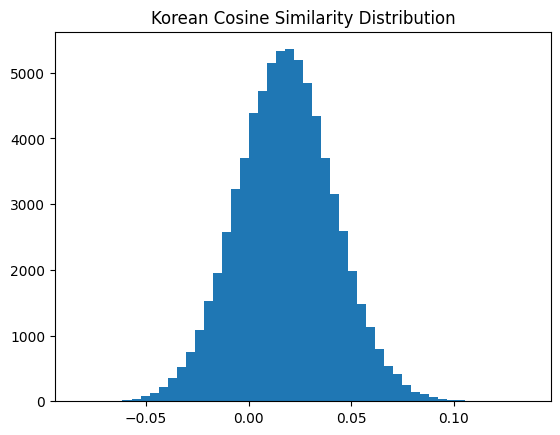

In [60]:
import matplotlib.pyplot as plt

cos_sim_kor = evaluate_student_teacher(
    test_tgt, 
    student_model=student_model,       # 학습 후
    teacher_model=teacher_model, 
    student_tokenizer=student_tokenizer,
    projection=projection,
    device=DEVICE
)

print("Korean Cosine Similarity")
print("Mean:", cos_sim_kor.mean().item(), "Std:", cos_sim_kor.std().item())

# 시각화
plt.hist(cos_sim_kor.cpu().numpy(), bins=50)
plt.title("Korean Cosine Similarity Distribution")
plt.show()